In [ ]:
!unzip /content/drive/MyDrive/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/val/Peach___Bacterial_spot/image (1273).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (1273).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (640).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (640).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (2132).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (2132).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (2098).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (2098).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (80).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (80).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (1933).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (1933).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (494).JPG  
  inflating: __MACO

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6331db59-44b3-6142-3600-b3292d530c11)


### Import Libraries

In [204]:
import datetime
import glob
import itertools
import os
import random
import shutil

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from PIL import Image as im
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Dropout, Input,
                                     MaxPool2D)
from tensorflow.keras.losses import (CategoricalCrossentropy,
                                     SparseCategoricalCrossentropy)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)


In [205]:
train_dir='/content/Dataset/train'
valid_dir='/content/Dataset/val'
test_dir='/content/Dataset/test'

In [206]:
train_gen = tf.keras.utils.image_dataset_from_directory(directory="/content/Dataset/train",
                                                        image_size=(256, 256),
                                                        batch_size = 32
                                                        )
val_gen = tf.keras.utils.image_dataset_from_directory(directory="/content/Dataset/val",
                                                       image_size=(256, 256),
                                                       batch_size = 32)

rescale = tf.keras.layers.Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
val_gen  = val_gen.map(lambda image,label:(rescale(image),label))

test_gen = tf.keras.utils.image_dataset_from_directory(directory="/content/Dataset/test",image_size=(256, 256))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 42230 files belonging to 38 classes.
Found 9042 files belonging to 38 classes.
Found 9071 files belonging to 38 classes.


### Model1: Teacher Network

In [207]:
from tensorflow.keras.applications.vgg16 import VGG16

In [208]:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(256,256,3))
print(f"Network Length:{len(base_model.layers)}")

for layer in base_model.layers:
  layer.trainable = False

x = layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(38, activation="softmax")(x)
teacher_model = Model(inputs=base_model.input,outputs= x) #linear activation to get pre-soft logits

opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
teacher_model.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

teacher_model.summary()

Network Length:19
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 

**Extracted Parameters = 31 Million parameters**

In [209]:
# !mkdir /content/drive/MyDrive/KnowDist
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
filepath="/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-teacher(VGG)_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [earlystop,checkpoint]

### Train Model

In [210]:
History = teacher_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=10,
                            shuffle=True,
                            callbacks=callbacks,
                            use_multiprocessing=True, 
                            workers=10,
                            )

Epoch 1/10
1320/1320 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8622
Epoch 1: val_loss improved from inf to 0.20415, saving model to /content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-teacher(VGG)_model.hdf5
1320/1320 [==============================] - 160s 121ms/step - loss: 0.4971 - accuracy: 0.8622 - val_loss: 0.2041 - val_accuracy: 0.9424
Epoch 2/10
1320/1320 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9607
Epoch 2: val_loss improved from 0.20415 to 0.15261, saving model to /content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-teacher(VGG)_model.hdf5
1320/1320 [==============================] - 161s 122ms/step - loss: 0.1588 - accuracy: 0.9607 - val_loss: 0.1526 - val_accuracy: 0.9569
Epoch 3/10
1320/1320 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9793
Epoch 3: val_loss improved from 0.15261 to 0.13609, saving model to /content/drive/MyDrive/Col

### Load best teacher model weight and save the model

In [211]:
teacher_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-teacher(VGG)_model.hdf5")
teacher_model.save("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/VGG16/")

### Print Model Statistics

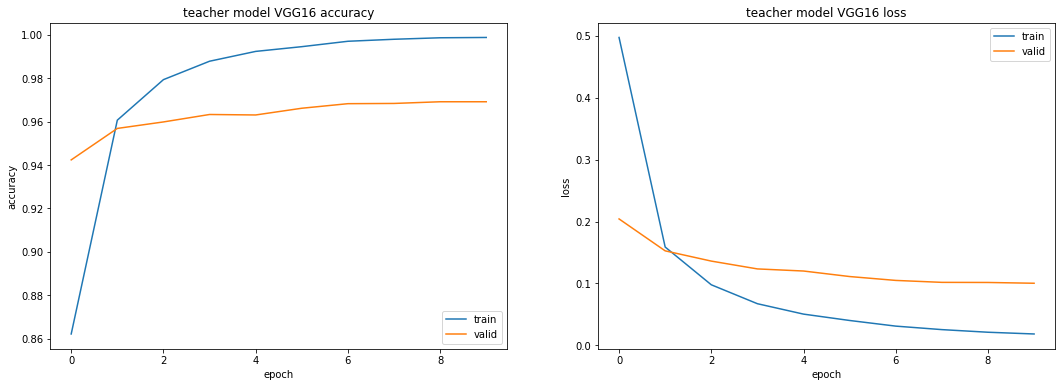

In [212]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))  

# summarize history for accuracy
plt.subplot(121)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('teacher model VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('teacher model VGG16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [213]:
print(teacher_model.metrics_names) 
loss, acc = teacher_model.evaluate(val_gen, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

['loss', 'accuracy']
283/283 [==============================] - 28s 98ms/step - loss: 0.1003 - accuracy: 0.9691
test loss =  0.10032136738300323
test accuracy =  0.9691439867019653


In [214]:
from tqdm import tqdm
labels = []
predictions = []
for x,y in tqdm(val_gen):
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(teacher_model.predict(x),1).numpy())

100%|██████████| 283/283 [00:44<00:00,  6.43it/s]


In [215]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

### Teacher Model Performance

In [216]:
from sklearn.metrics import classification_report,cohen_kappa_score,matthews_corrcoef
print(f"Model VGG16 : Teacher Model \n")
print(classification_report(labels, predictions))

cohen_kappa_score = cohen_kappa_score(labels, predictions)
Metthews_correlation = matthews_corrcoef(labels, predictions)

print("Cohen Kappa Score: ", cohen_kappa_score)
print("Matthews correlation coefficient : ", Metthews_correlation)

Model VGG16 : Teacher Model 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       150
           1       0.99      0.98      0.99       150
           2       0.99      0.99      0.99       150
           3       0.96      0.97      0.96       246
           4       0.99      1.00      0.99       225
           5       1.00      1.00      1.00       157
           6       0.98      0.98      0.98       150
           7       0.90      0.97      0.93       150
           8       0.99      0.99      0.99       178
           9       0.97      0.87      0.92       150
          10       0.99      1.00      0.99       174
          11       0.98      0.94      0.96       177
          12       0.95      0.98      0.96       207
          13       1.00      1.00      1.00       161
          14       1.00      1.00      1.00       150
          15       1.00      1.00      1.00       826
          16       1.00      0.98      0.99       3

Teacher Model VGG16 : Confusion Matrix


<Figure size 1440x360 with 0 Axes>

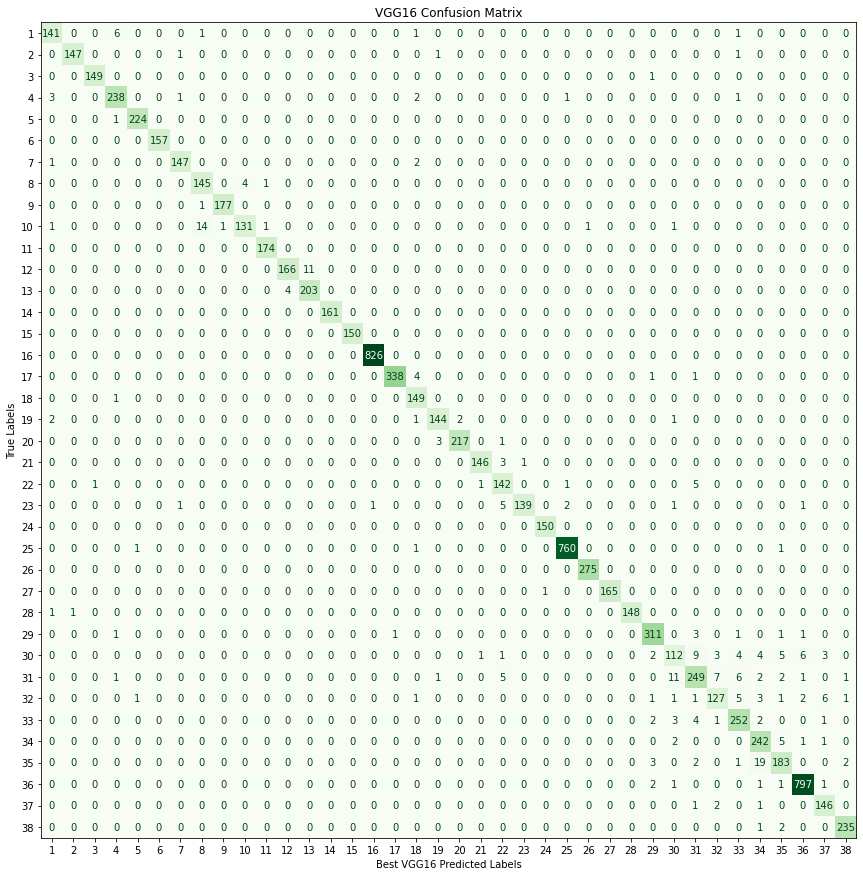

In [217]:
print("Teacher Model VGG16 : Confusion Matrix")

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Greens')
plt.title("VGG16 Confusion Matrix")
plt.xlabel('Best VGG16 Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model2:Student Model

In [218]:
# del model
input = Input(shape=(256,256,3))
# Layer:1 
x = tf.keras.layers.Conv2D(16,(3,3),activation="relu",padding="same")(input)
x = tf.keras.layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3,3)(x)
# Layer:2
x = tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3,3)(x)
# Layer:3
x = tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3,3)(x)
# Layer:4
x = tf.keras.layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
# Layer:5
x = tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same")(x)
# Layer:6
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(38,activation="softmax")(x)

student_model = tf.keras.Model(inputs = input, outputs = output, name="student_model")
student_model.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
student_model.summary()

Model: "student_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_130 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 conv2d_131 (Conv2D)         (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 85, 85, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 85, 85, 32)        4640      
                                                                 
 conv2d_133 (Conv2D)         (None, 85, 85, 32)        9248      
                                                     

In [219]:
# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student_model)

### Distiller Class

In [220]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=2,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        #model = ...  # create the original model
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss +  distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [221]:
dist_earlystop = EarlyStopping(monitor='distillation_loss', patience=5, verbose=1)
# filepath="/content/drive/MyDrive/KnowDist/weights-distil.h5"
# dist_checkpoint = ModelCheckpoint(filepath=filepath, monitor='distillation_loss', verbose=1, save_best_only=True, mode='min')
dist_callbacks = [dist_earlystop]

### DistillerModel trained on Temprature = 2

In [222]:
# Initialize and compile distiller
# del distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),
                  metrics=['accuracy'],
                  student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  distillation_loss_fn=tf.keras.losses.KLDivergence(),
                  alpha=0.5,
                  temperature=2)

# Distill teacher to student
distiller_hist = distiller.fit(train_gen, 
                               validation_data = val_gen, 
                               epochs=10,
                               shuffle=True,
                               callbacks = dist_callbacks,
                               use_multiprocessing=True,
                               workers = 10
                               )

Epoch 1/10
1320/1320 [==============================] - 179s 135ms/step - accuracy: 0.3345 - student_loss: 2.4670 - distillation_loss: 0.0034 - val_accuracy: 0.5617 - val_student_loss: 1.9220
Epoch 2/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.5727 - student_loss: 1.4629 - distillation_loss: 0.0024 - val_accuracy: 0.6785 - val_student_loss: 1.6953
Epoch 3/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.6629 - student_loss: 1.1231 - distillation_loss: 0.0019 - val_accuracy: 0.7092 - val_student_loss: 1.0658
Epoch 4/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.7160 - student_loss: 0.9320 - distillation_loss: 0.0017 - val_accuracy: 0.7763 - val_student_loss: 0.5087
Epoch 5/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.7482 - student_loss: 0.8276 - distillation_loss: 0.0015 - val_accuracy: 0.7892 - val_student_loss: 0.4371
Epoch 6/10
1320/1320 [==================

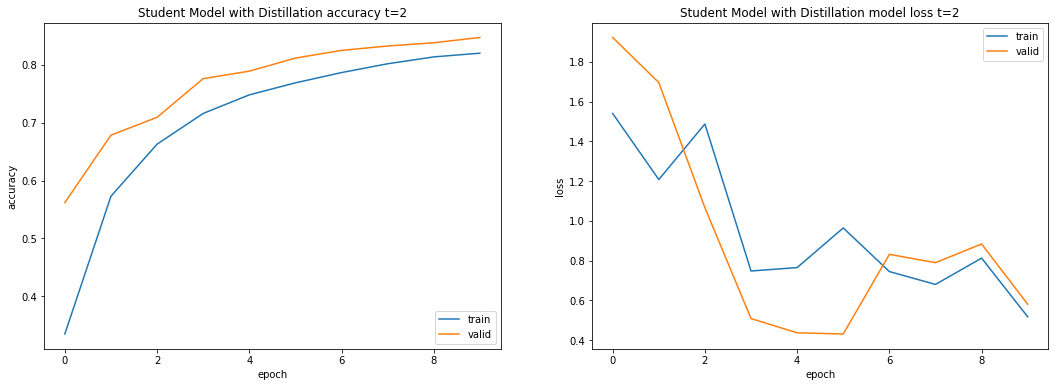

In [223]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(distiller_hist.history['accuracy'])
plt.plot(distiller_hist.history['val_accuracy'])
plt.title('Student Model with Distillation accuracy t=2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(distiller_hist.history['student_loss'])
plt.plot(distiller_hist.history['val_student_loss'])
plt.title('Student Model with Distillation model loss t=2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [224]:
print(distiller.metrics_names)
acc, loss = distiller.evaluate(val_gen, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

['accuracy']
283/283 [==============================] - 6s 21ms/step - accuracy: 0.8475 - student_loss: 0.4700
test loss =  0.47129201889038086
test accuracy =  0.8474894762039185


### DistillerModel trained on Temprature = 6

In [232]:
# Initialize and compile distiller
# del distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),
                  metrics=['accuracy'],
                  student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  distillation_loss_fn=tf.keras.losses.KLDivergence(),
                  alpha=0.5,
                  temperature=6)

# Distill teacher to student
distiller_hist = distiller.fit(train_gen, 
                               validation_data = val_gen, 
                               epochs=10,
                               shuffle=True,
                               callbacks = dist_callbacks,
                               use_multiprocessing=True,
                               workers = 10
                               )

Epoch 1/10
1320/1320 [==============================] - 180s 135ms/step - accuracy: 0.8754 - student_loss: 0.3887 - distillation_loss: 7.0635e-05 - val_accuracy: 0.8765 - val_student_loss: 0.0977
Epoch 2/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.9111 - student_loss: 0.2719 - distillation_loss: 5.0835e-05 - val_accuracy: 0.9164 - val_student_loss: 0.0735
Epoch 3/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.9284 - student_loss: 0.2180 - distillation_loss: 4.0817e-05 - val_accuracy: 0.9239 - val_student_loss: 0.0536
Epoch 4/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.9384 - student_loss: 0.1839 - distillation_loss: 3.4952e-05 - val_accuracy: 0.9268 - val_student_loss: 0.1420
Epoch 5/10
1320/1320 [==============================] - 178s 135ms/step - accuracy: 0.9474 - student_loss: 0.1588 - distillation_loss: 3.0350e-05 - val_accuracy: 0.9226 - val_student_loss: 0.2014
Epoch 6/10
1320/1320

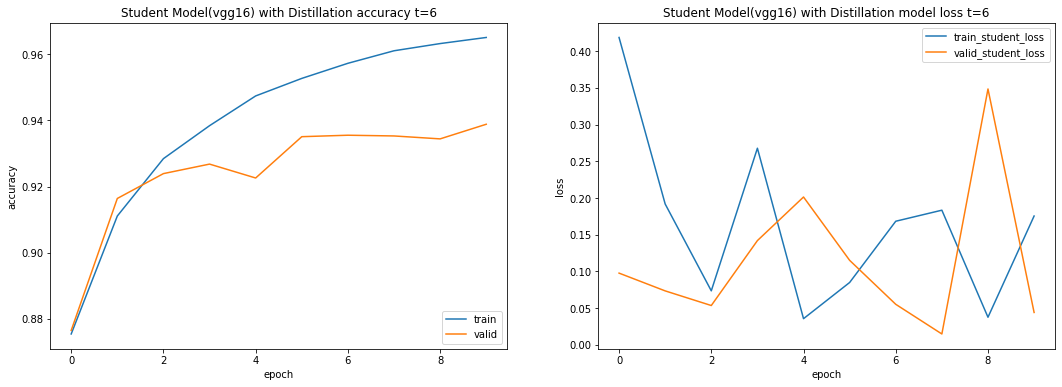

In [240]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(distiller_hist.history['accuracy'])
plt.plot(distiller_hist.history['val_accuracy'])
plt.title('Student Model(vgg16) with Distillation accuracy t=6')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(distiller_hist.history['student_loss'])
plt.plot(distiller_hist.history['val_student_loss'])
plt.title('Student Model(vgg16) with Distillation model loss t=6')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_student_loss', 'valid_student_loss'], loc='upper right')
plt.show()

In [234]:
print(distiller.metrics_names)
acc, loss = distiller.evaluate(val_gen, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

['accuracy']
283/283 [==============================] - 6s 20ms/step - accuracy: 0.9388 - student_loss: 0.2022
test loss =  0.009992491453886032
test accuracy =  0.9388409852981567


In [235]:
student_model.save("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/VGG16_distilation_new.hdf5")

In [236]:
from tqdm import tqdm
labels = []
predictions = []
for x,y in tqdm(val_gen):
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(student_model.predict(x),1).numpy())

100%|██████████| 283/283 [00:22<00:00, 12.77it/s]


In [237]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

### Distiller Model Performance

Model : Distiller Model 

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       150
           1       0.95      0.93      0.94       150
           2       0.97      0.95      0.96       150
           3       0.92      0.94      0.93       246
           4       0.90      0.96      0.93       225
           5       0.94      0.98      0.96       157
           6       0.95      0.95      0.95       150
           7       0.79      0.83      0.81       150
           8       0.99      0.99      0.99       178
           9       0.85      0.81      0.83       150
          10       0.97      0.99      0.98       174
          11       0.95      0.90      0.92       177
          12       0.92      0.97      0.94       207
          13       0.99      0.98      0.99       161
          14       0.95      0.99      0.97       150
          15       0.99      1.00      0.99       826
          16       0.95      0.94      0.95       344
 

<Figure size 1440x360 with 0 Axes>

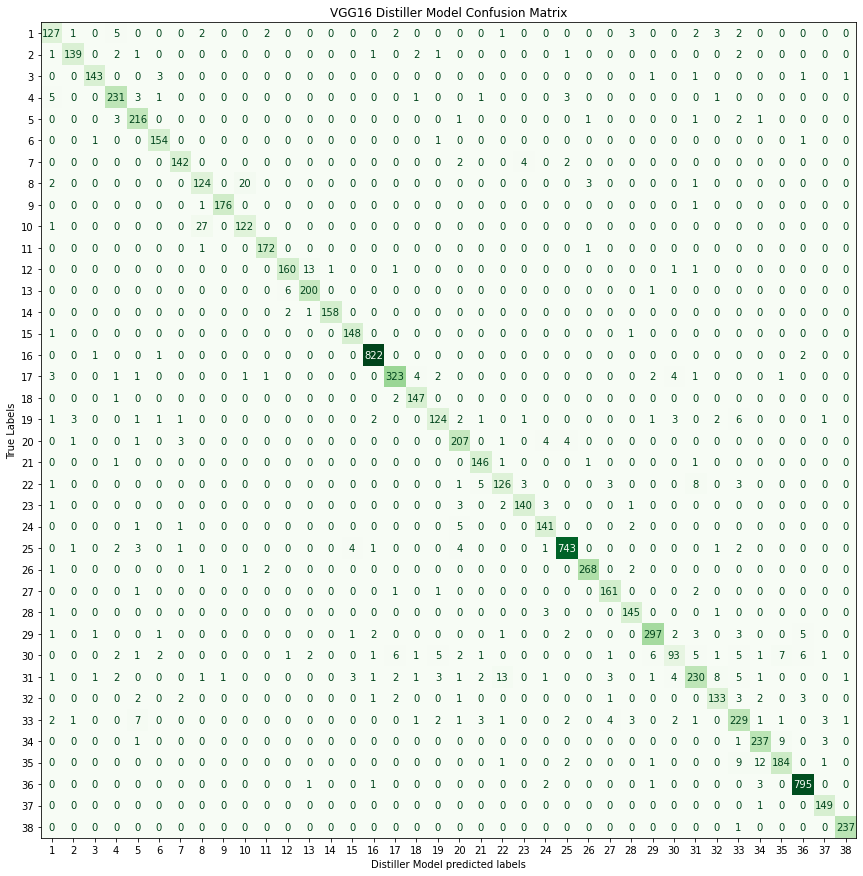

In [238]:
from sklearn.metrics import classification_report,cohen_kappa_score,matthews_corrcoef
print(f"Model : Distiller Model \n")
print(classification_report(labels, predictions))

cohen_kappa_score = cohen_kappa_score(labels, predictions)
Metthews_correlation = matthews_corrcoef(labels, predictions)

print("Cohen Kappa Score: ", cohen_kappa_score)
print("Matthews correlation coefficient : ", Metthews_correlation)

print("Distiller Model(VGG16) : Confusion Matrix")

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Greens')
plt.title("VGG16 and CNN Distiller Model Confusion Matrix")
plt.xlabel('Distiller Model predicted labels')
plt.ylabel('True Labels')
plt.show()

### Train Student Model without Knowledge Distillation

In [239]:
stu_earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
filepath="/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-student_model.hdf5"
stu_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
stu_callbacks = [stu_earlystop,stu_checkpoint]

In [192]:
# Train student as doen usually
student_scratch.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
stu_history = student_scratch.fit(train_gen,
                            validation_data=val_gen,
                            epochs=10,
                            shuffle=True,
                            callbacks=stu_callbacks,
                            use_multiprocessing=True, 
                            workers=10,
                            )

Epoch 1/10
1320/1320 [==============================] - ETA: 0s - loss: 3.2205 - accuracy: 0.1690
Epoch 1: val_loss improved from inf to 2.96952, saving model to /content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-student_model.hdf5
1320/1320 [==============================] - 65s 48ms/step - loss: 3.2205 - accuracy: 0.1690 - val_loss: 2.9695 - val_accuracy: 0.2169
Epoch 2/10
1320/1320 [==============================] - ETA: 0s - loss: 2.9341 - accuracy: 0.2245
Epoch 2: val_loss improved from 2.96952 to 2.75258, saving model to /content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-student_model.hdf5
1320/1320 [==============================] - 67s 51ms/step - loss: 2.9341 - accuracy: 0.2245 - val_loss: 2.7526 - val_accuracy: 0.2757
Epoch 3/10
1320/1320 [==============================] - ETA: 0s - loss: 2.7287 - accuracy: 0.2706
Epoch 3: val_loss improved from 2.75258 to 2.54608, saving model to /content/drive/MyDrive/Colab Notebooks/K

In [193]:
student_scratch.load_weights("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/weights-student_model.hdf5")
student_scratch.save("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/vggmodel/student_model/")

### Print Student Model Statistics

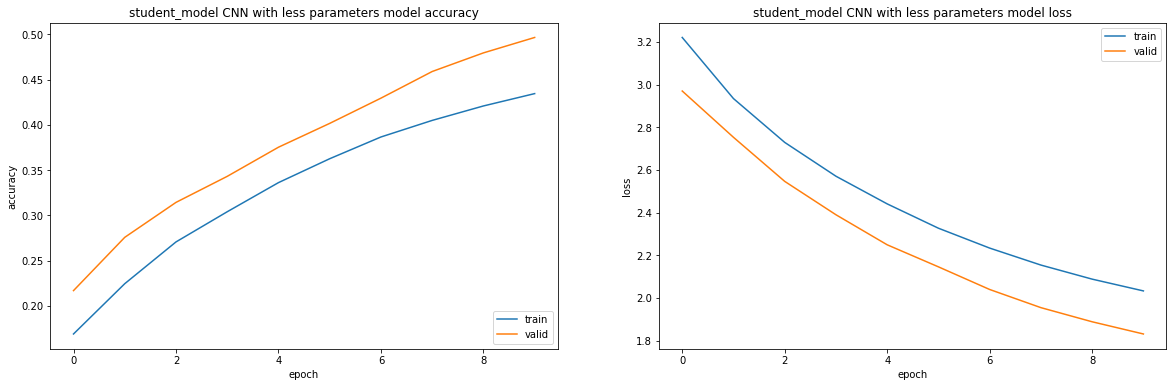

In [199]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(stu_history.history['accuracy'])
plt.plot(stu_history.history['val_accuracy'])
plt.title('student_model CNN with less parameters model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(stu_history.history['loss'])
plt.plot(stu_history.history['val_loss'])
plt.title('student_model CNN with less parameters model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [200]:
print(student_scratch.metrics_names) 
loss, acc = student_scratch.evaluate(val_gen, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

['loss', 'accuracy']
283/283 [==============================] - 6s 21ms/step - loss: 1.8310 - accuracy: 0.4965
test loss =  1.8309695720672607
test accuracy =  0.4964609742164612


In [201]:
from tqdm import tqdm
labels = []
predictions = []
for x,y in tqdm(val_gen):
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(student_scratch.predict(x),1).numpy())

100%|██████████| 283/283 [00:21<00:00, 12.99it/s]


In [202]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

### Student Model Performance

Model : CNN Student Model 

              precision    recall  f1-score   support

           0       0.27      0.05      0.09       150
           1       0.36      0.35      0.35       150
           2       0.29      0.03      0.05       150
           3       0.48      0.36      0.41       246
           4       0.28      0.31      0.29       225
           5       0.08      0.01      0.01       157
           6       0.41      0.30      0.35       150
           7       0.29      0.01      0.03       150
           8       0.56      0.87      0.68       178
           9       0.40      0.32      0.36       150
          10       0.59      0.59      0.59       174
          11       0.41      0.49      0.45       177
          12       0.32      0.48      0.39       207
          13       0.61      0.52      0.56       161
          14       0.38      0.08      0.13       150
          15       0.75      0.90      0.82       826
          16       0.52      0.58      0.55       344

<Figure size 1440x360 with 0 Axes>

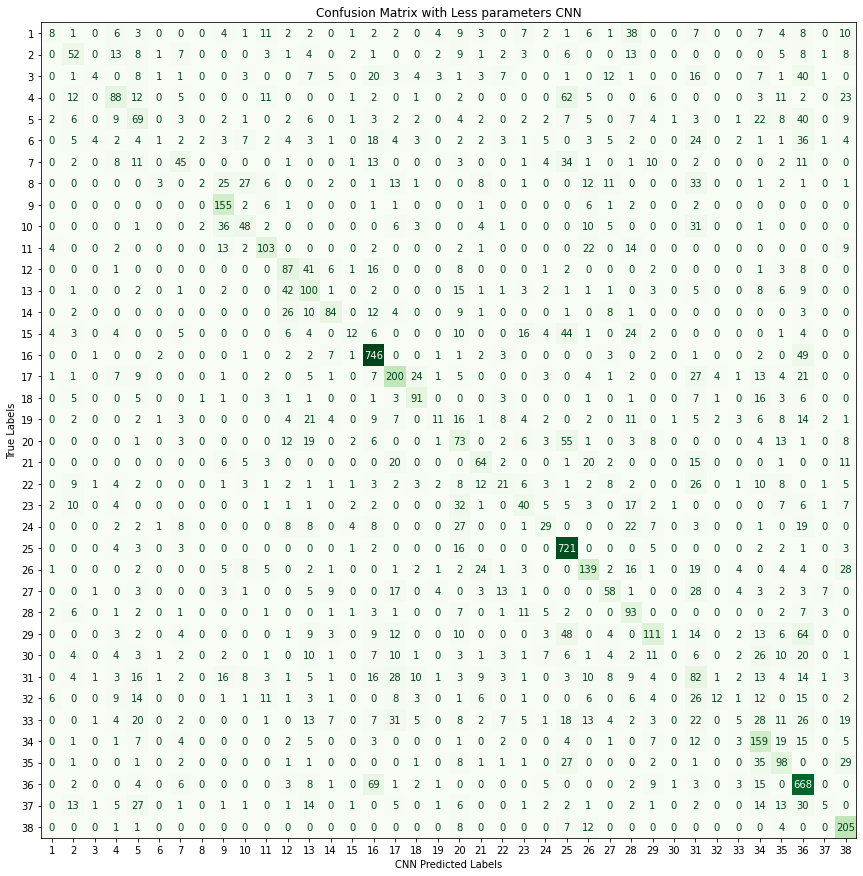

In [203]:
from sklearn.metrics import classification_report,cohen_kappa_score,matthews_corrcoef
print(f"Model : CNN Student Model \n")
print(classification_report(labels, predictions))

cohen_kappa_score = cohen_kappa_score(labels, predictions)
Metthews_correlation = matthews_corrcoef(labels, predictions)

print("Cohen Kappa Score: ", cohen_kappa_score)
print("Matthews correlation coefficient : ", Metthews_correlation)

print("Teacher Model : Confusion Matrix")

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Greens')
plt.title("Confusion Matrix with Less parameters CNN")
plt.xlabel('CNN Predicted Labels')
plt.ylabel('True Labels')
plt.show()

| Sr.No | Model Name | Parameters | HyperParameter |Test Accuracy(%)(10 epochs)                                                         |
| ----- | ----- |-------------------------------------------- | -------| ------------------------------------------------------------ |
| 1     | Teacher Model(VGG16) | 31M | - | 96.99|
| 2     | Student Model with Distillation| 13M |α = 0.5, t = 2 | 84.74 |
| 3     | Student Model with Distillation| 13M | α = 0.5, t = 6 | 94.00 |
| 4     | Student Model without Distillation | 13M | - | 53.17 |